# PTB-DB Heartbeat Classifier (Normal vs Abnormal)

This notebook trains a 1D-CNN on the **PTB Diagnostic ECG Database** subset from the Kaggle Heartbeat dataset by Shayan Fazeli, **when only** `ptbdb_normal.csv` and `ptbdb_abnormal.csv` are provided.

It will:
- Load `ptbdb_normal.csv` and `ptbdb_abnormal.csv`
- Concatenate them and **stratified split** into train/val/test
- Standardize per-beat, build a compact **Keras 1D-CNN**
- Report Accuracy, Macro F1, ROC-AUC; plot Confusion Matrix and ROC curve
- Provide `predict_proba()` helper

## Setup & imports

In [1]:
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

DATA_DIR = './heartbeat'

print('Using DATA_DIR =', DATA_DIR)

Using DATA_DIR = ./heartbeat


## Load PTB-DB from `ptbdb_normal.csv` and `ptbdb_abnormal.csv`
Each CSV usually has **187 samples + 1 label column**. If labels are missing, we will infer them: normal→0, abnormal→1.

In [2]:
def load_ptbdb_twofiles(normal_csv='ptbdb_normal.csv', abnormal_csv='ptbdb_abnormal.csv'):
    n_path = os.path.join(DATA_DIR, normal_csv)
    a_path = os.path.join(DATA_DIR, abnormal_csv)
    if not os.path.exists(n_path) or not os.path.exists(a_path):
        raise FileNotFoundError('Could not find ptbdb_normal.csv or ptbdb_abnormal.csv in DATA_DIR')

    n = pd.read_csv(n_path, header=None)
    a = pd.read_csv(a_path, header=None)

    # If label column absent, add it
    if n.shape[1] == 187:  # no label
        n['label'] = 0
    if a.shape[1] == 187:
        a['label'] = 1

    # If label present but not binary, force it
    if n.shape[1] == 188:
        n.iloc[:, -1] = 0
    if a.shape[1] == 188:
        a.iloc[:, -1] = 1

    df = pd.concat([n, a], axis=0, ignore_index=True)
    X = df.iloc[:, :-1].values.astype('float32')
    y = df.iloc[:, -1].values.astype('int64')
    return X, y

def standardize_per_example(X):
    mu = X.mean(axis=1, keepdims=True)
    sd = X.std(axis=1, keepdims=True) + 1e-6
    return (X - mu)/sd

def to_cnn_input(X):
    return X[..., None]

def class_weights_from_labels(y):
    c = Counter(y)
    total = sum(c.values())
    return {cls: total/(len(c)*cnt) for cls, cnt in c.items()}

In [3]:
X_all, y_all = load_ptbdb_twofiles()
print('Loaded:', X_all.shape, 'label dist:', Counter(y_all))

# Standardize, then split stratified into train/val/test (70/15/15)
X_all = standardize_per_example(X_all)
X_train, X_tmp, y_train, y_tmp = train_test_split(X_all, y_all, test_size=0.30, random_state=SEED, stratify=y_all)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.50, random_state=SEED, stratify=y_tmp)

X_train_cnn = to_cnn_input(X_train)
X_val_cnn   = to_cnn_input(X_val)
X_test_cnn  = to_cnn_input(X_test)

print('Shapes (train/val/test):', X_train_cnn.shape, X_val_cnn.shape, X_test_cnn.shape)
cls_weights = class_weights_from_labels(y_train)
print('Class weights:', cls_weights)

Loaded: (14552, 187) label dist: Counter({np.int64(1): 10506, np.int64(0): 4046})
Shapes (train/val/test): (10186, 187, 1) (2183, 187, 1) (2183, 187, 1)
Class weights: {np.int64(1): 0.6925482730486809, np.int64(0): 1.7983757062146892}


In [4]:
import numpy as np
# Check distributions
print('y_train bincount:', np.bincount(y_train))
print('y_val   bincount:', np.bincount(y_val))
print('y_test  bincount:', np.bincount(y_test))

# Double-check unique labels
print('unique labels (all):', np.unique(np.concatenate([y_train, y_val, y_test])))


y_train bincount: [2832 7354]
y_val   bincount: [ 607 1576]
y_test  bincount: [ 607 1576]
unique labels (all): [0 1]


## Build 1D-CNN (binary)

In [5]:
def build_cnn_binary(input_length=187):
    inp = keras.Input(shape=(input_length, 1))
    x = layers.Conv1D(32, 7, padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(64, 5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn_binary()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 187, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 187, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 187, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 93, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 93, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 93, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 46, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 46, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,185 (270.25 KB)

 Trainable params: 68,737 (268.50 KB)

 Non-trainable params: 448 (1.75 KB)

## Train

In [11]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.array([0, 1])
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight = {0: cw[0], 1: cw[1]}
print('class_weight:', class_weight)

# Train with these weights
callbacks = [
    keras.callbacks.EarlyStopping(patience=12, restore_best_weights=True, monitor='val_loss'),
    keras.callbacks.ModelCheckpoint('best_ptbdb_cnn.keras', save_best_only=True, monitor='val_loss')
]
history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=50,
    batch_size=256,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)


class_weight: {0: np.float64(1.7983757062146892), 1: np.float64(0.6925482730486809)}
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9159 - loss: 0.2200 - val_accuracy: 0.7219 - val_loss: 0.9811
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9389 - loss: 0.1624 - val_accuracy: 0.7219 - val_loss: 1.2775
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9543 - loss: 0.1262 - val_accuracy: 0.7219 - val_loss: 1.3286
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9655 - loss: 0.1012 - val_accuracy: 0.7219 - val_loss: 1.4007
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9742 - loss: 0.0764 - val_accuracy: 0.7219 - val_loss: 1.5208
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9808 - loss: 0.0628 - val_accuracy: 0.7219 - val_loss: 1.5274
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9826 - loss: 0.0529 - val_accuracy: 0.7219 - val_loss: 1.4547
Epoch 8/50
40/40 ━━━━━━━━━

## Curves

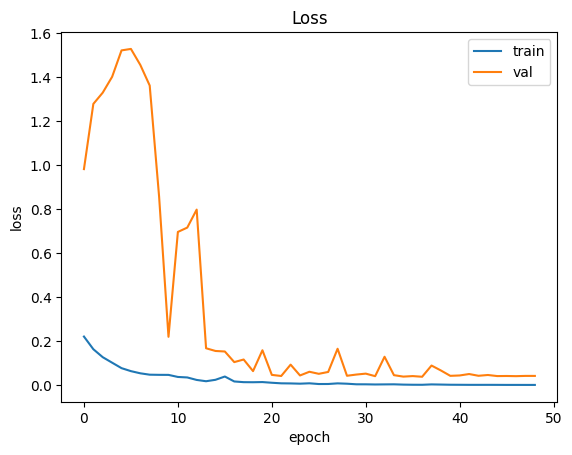

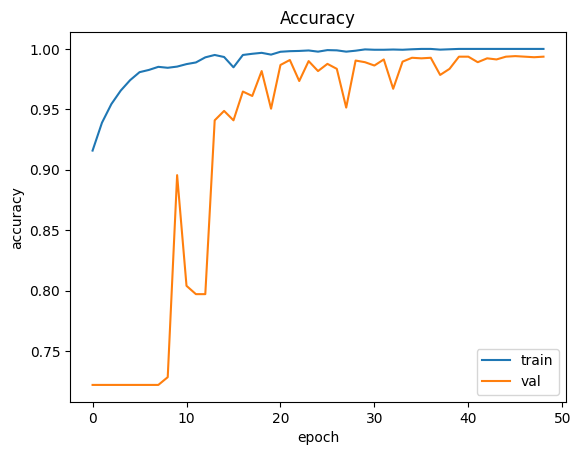

In [12]:
plt.figure(); plt.plot(history.history['loss'], label='train'); plt.plot(history.history['val_loss'], label='val'); plt.legend(); plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('Loss'); plt.show()
plt.figure(); plt.plot(history.history['accuracy'], label='train'); plt.plot(history.history['val_accuracy'], label='val'); plt.legend(); plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.title('Accuracy'); plt.show()

## Evaluate + Confusion Matrix (graphical) + ROC

Test Accuracy: 0.9945
Macro F1: 0.9931
ROC-AUC: 0.9997

Confusion Matrix (raw counts):
 [[ 600    7]
 [   5 1571]]


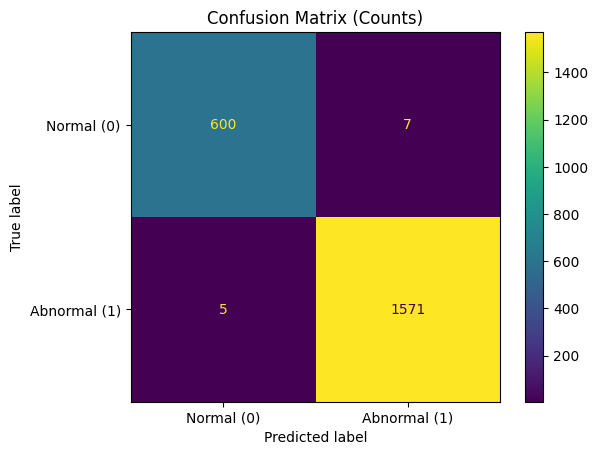

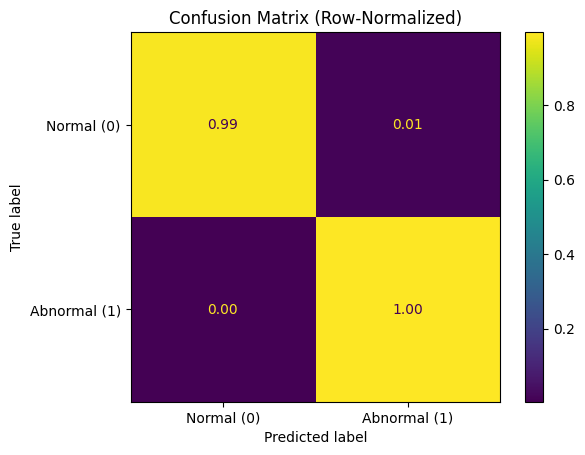

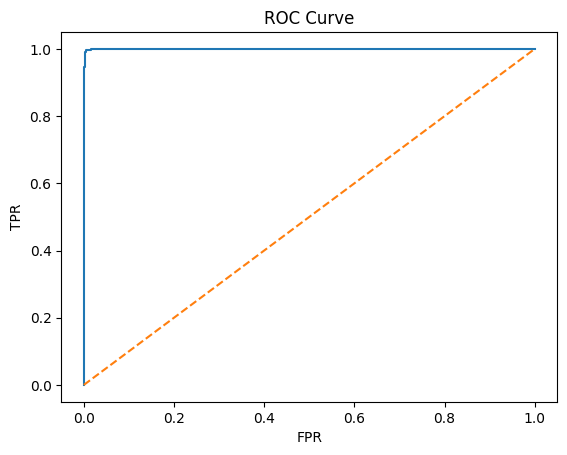

In [13]:
def evaluate_model_binary(model, X, y):
    prob = model.predict(X, verbose=0).ravel()
    pred = (prob >= 0.5).astype(int)
    acc = accuracy_score(y, pred)
    f1m = f1_score(y, pred, average='macro')
    cm  = confusion_matrix(y, pred)
    auc = roc_auc_score(y, prob)
    return acc, f1m, auc, cm, prob, pred

acc, f1m, auc, cm, prob_test, pred_test = evaluate_model_binary(model, X_test_cnn, y_test)
print(f'Test Accuracy: {acc:.4f}\nMacro F1: {f1m:.4f}\nROC-AUC: {auc:.4f}\n')
print('Confusion Matrix (raw counts):\n', cm)

# Plot confusion matrix (counts)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal (0)', 'Abnormal (1)'])
disp.plot(values_format='d')
plt.title('Confusion Matrix (Counts)')
plt.show()

# Plot normalized confusion matrix (percentages)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=['Normal (0)', 'Abnormal (1)'])
disp.plot(values_format='.2f')
plt.title('Confusion Matrix (Row-Normalized)')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, prob_test)
plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1], [0,1], linestyle='--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.show()

## Inference

In [16]:
def predict_proba(row_187):
    x = np.asarray(row_187, dtype='float32')
    assert x.shape[0] == 187, 'Expected 187 features for a heartbeat.'
    mu, sd = x.mean(), x.std() + 1e-6
    x = (x - mu)/sd
    x = x[None, :, None]
    p = model.predict(x, verbose=0).ravel()[0]
    return float(p)  # probability of Abnormal (1)

example_prob = predict_proba(X_test[0])
example_prob

3.7900210259067535e-07

In [17]:
model.save('ptbdb_cnn_final.keras')
print('Saved ptbdb_cnn_final.keras')

Saved ptbdb_cnn_final.keras
